##### Copyright 2020 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title ##### Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Masked Autoregressive Flow on JAX

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/autoregressive_flow_on_jax"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/autoregressive_flow_on_jax.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/autoregressive_flow_on_jax.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/autoregressive_flow_on_jax.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

This notebook illustrates Masked Autoregressive Flow (MAF) on the JAX substrate. 

Expressive families of distributions can be built by transforming samples from a simple base distribution using parametrized bijectors. This class of methods is often called "normalizing flows". In MAF, the bijector parameters are generated by NNs that express the conditional dependencies between random variables. There are now a handful of options for building NNs in JAX. In this example, we use Haiku to build the conditioning networks.

Haiku uses context managers (via `haiku.transform`) to build and track parameters and state. In this example, since only the bijectors are parametrized using Haiku, one option would be to `haiku.transform` the methods of the final bijector and pass the parameters to `TransformedDistribution` using `bijector_kwargs`. The approach taken below is to instead `haiku.transform` the top-level functions, such as sampling and density evaluation. In the case where the flow is used within or alongside other Haiku modules, working with and reasoning about a single set of top-level transforms seems to be easier.

In [2]:
!pip install -q --upgrade tfp-nightly dm-haiku

import functools

import numpy as np
import haiku as hk

import jax
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Make synthetic dataset

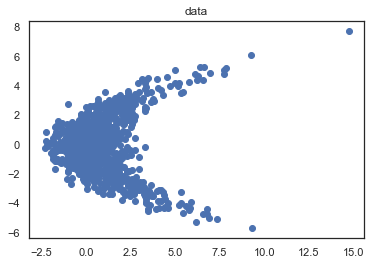

In [3]:
N = 1000
np.random.seed(213)
x2 = np.random.randn(N).astype(dtype=np.float32) * 2.
x1 = np.random.randn(N).astype(dtype=np.float32) + (x2 * x2 / 4.)
X = np.stack([x1, x2], axis=-1)
K = X.shape[-1]

plt.scatter(*X.T)
plt.title('data');

## Build the distribution 

In [4]:
from haiku._src import base as hk_base
from haiku.experimental import name_scope

class MaskedLinear(hk.Linear):
    """Linear module that applies a fixed boolean mask"""

    def __init__(self,
               mask,
               with_bias = True,
               w_init = None,
               b_init = None,
               name = None):
        
        assert len(mask.shape) == 2
        super().__init__(mask.shape[-1], with_bias, w_init, b_init, name=name)
        self.mask = mask

    def __call__(self, inputs):

        self.input_size = inputs.shape[-1]
        default_stddev = 1. / np.sqrt(self.input_size)
        w_init = self.w_init or hk.initializers.TruncatedNormal(stddev=default_stddev)

        w = hk_base.get_parameter("w", [self.input_size, self.output_size],
                               inputs.dtype, init=w_init)
        # This method only differs from Linear in this mask application
        out = jnp.dot(inputs, w * self.mask)
        if self.with_bias:
            b = hk_base.get_parameter("b", [self.output_size], inputs.dtype,
                                   init=self.b_init)
            out += jnp.broadcast_to(b, out.shape)
        return out
    
    
class ConditionalMaskedAutoregressiveBijector(hk.Module):
    
    def __init__(self, bijector_fn, n_params, hidden_dims, *args, **kwargs):
        """
        Args:
          bijector_fn: (jnp.array with inputs and params as trailing dims) -> tfb.Bijector
          n_params: number of parameters in the bijector for each input dimension
          hidden_dims: see _make_dense_autoregressive_masks
        """
        
        super().__init__(*args, **kwargs)
        self.bijector_fn = bijector_fn
        self.n_params = n_params
        self.hidden_dims = hidden_dims
    
    def __call__(self, y):
        
        n_inputs = y.shape[-1]
        broadcast_dims = y.shape[:-1]

        masks = tfb.masked_autoregressive._make_dense_autoregressive_masks(
            self.n_params,
            n_inputs, 
            self.hidden_dims, 
            input_order='left-to-right'
        )        

        for mask in masks[:-1]:
            y = MaskedLinear(mask)(y)
            y = jax.nn.sigmoid(y)
        y = MaskedLinear(masks[-1])(y)
        
        # Unravel the inputs and parameters
        params = y.reshape(broadcast_dims + (n_inputs, self.n_params))
        
        return self.bijector_fn(params)
    

def build_bijector():
    
    def make_shift_and_scale(params):
        return tfb.Shift(params[..., 0])(tfb.Scale(log_scale=params[..., 1]))

    with name_scope('chain'):
        
        return tfb.Chain([
            tfb.MaskedAutoregressiveFlow(
                bijector_fn=ConditionalMaskedAutoregressiveBijector(
                    bijector_fn=make_shift_and_scale,
                    n_params=2,
                    name='made_1',
                    hidden_dims=(2, 2)
                )
            ),
            tfb.Permute(list(reversed(range(K)))),
            tfb.MaskedAutoregressiveFlow(
                bijector_fn=ConditionalMaskedAutoregressiveBijector(
                    bijector_fn=make_shift_and_scale,
                    n_params=2,
                    name='made_2',
                    hidden_dims=(2, 2)
                )
            )
        ])

    
def build_dist():
    dist = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=(K,)),
        bijector=build_bijector()
    )
    return dist


@hk.transform
def forward(*args, **kwargs): 
    return build_bijector().forward(*args, **kwargs)

@hk.transform
def inverse(*args, **kwargs):
    return build_bijector().inverse(*args, **kwargs)

@hk.transform
def sample(*args, **kwargs):
    return build_dist().sample(seed=hk.next_rng_key(), *args, **kwargs)

@hk.transform
def log_prob(*args, **kwargs):
    return build_dist().log_prob(*args, **kwargs)

## Maximize likelihood

In [5]:
def compute_loss(params, X):
    return -log_prob.apply(params, rng_key, X).mean()

@jax.jit
def step(rng_key, i, opt_state):
    value, grads = jax.value_and_grad(compute_loss)(get_params(opt_state), X)
    opt_state = opt_update(i, grads, opt_state)
    return value, opt_state

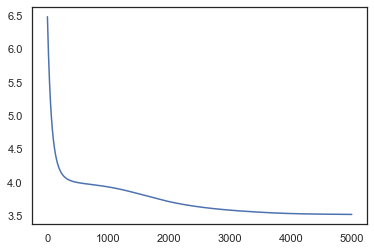

In [6]:
rng_key = jax.random.PRNGKey(0)

bijector_params = log_prob.init(
    rng_key,
    jnp.zeros(K))

opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(bijector_params)

losses = []
for i in range(5000):
    rng_key, subkey = jax.random.split(rng_key)
    loss, opt_state = step(rng_key, i, opt_state)
    losses.append(loss)
    
plt.plot(losses)

## Results

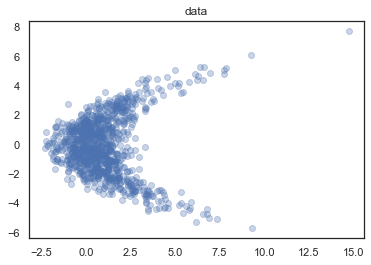

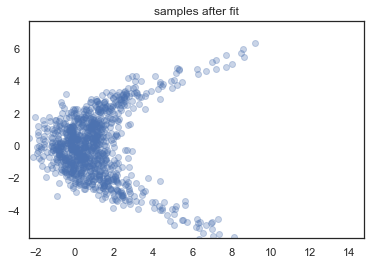

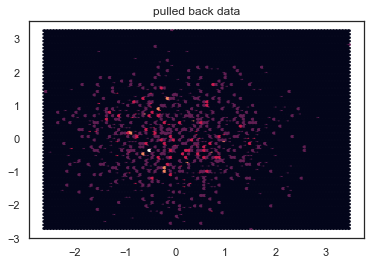

In [7]:
plt.scatter(*X.T, alpha=0.3)
plt.title('data')
plt.show()

plt.scatter(
    *sample.apply(
        get_params(opt_state),
        jax.random.PRNGKey(0),
        1000
    ).T,
    alpha=0.3
)
plt.title('samples after fit')
plt.xlim(X[:,0].min(),X[:,0].max())
plt.ylim(X[:,1].min(),X[:,1].max())
plt.show()

Z = inverse.apply(get_params(opt_state), jax.random.PRNGKey(0), X)
plt.hexbin(*Z.T)
plt.title('pulled back data')
plt.show()

## Issues

### Escaped tracers from `sample.init`

Using the params from `log_prob`, `sample.apply` works fine, but the parameter values from `sample.init` are escaped tracers. See [this haiku issue](https://github.com/deepmind/dm-haiku/issues/84)

In [8]:
@hk.transform
def sample(*args, **kwargs):
    return build_dist().sample(seed=hk.next_rng_key(), *args, **kwargs)

print(
    "Sampling using params from log_prob: ",
    sample.apply(
        log_prob.init(rng_key, jnp.zeros(K)),
        rng_key
    ),
)

print("Some of the params from sample:")
print(sample.init(rng_key)['chain/made_1/masked_linear_1'])

Sampling using params from log_prob:  [-2.086551    0.65518814]
Some of the params from sample:
FlatMapping({
  'w': Traced<ShapedArray(float32[2,2])>with<DynamicJaxprTrace(level=1/0)>,
  'b': Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>,
})
